# CIFAR-100 Training - Optimized for 74% Accuracy with HuggingFace Integration

## Key Improvements:
- Fixed data augmentation (proper Cutout implementation)
- Cosine annealing scheduler with warmup
- Optimized hyperparameters (batch size 256, MixUp alpha 0.2)
- Label smoothing (0.1)
- Gradient clipping
- Mixed precision training
- Model checkpointing and early stopping
- WideResNet-28-10 (36.5M parameters)
- **HuggingFace Hub integration with checkpoint uploads at breakpoints**

In [1]:
# Import Libraries
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
from torchsummary import summary
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime

# CIFAR-100 Mean and Std
cifar100_mean = (0.5071, 0.4865, 0.4409)
cifar100_std = (0.2673, 0.2564, 0.2761)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [11]:
checkpoint_dir = './drive/MyDrive/erav4'

# HuggingFace Setup - Get token from Colab secrets
try:
    from google.colab import userdata
    HF_TOKEN = userdata.get('HF_TOKEN')
    print("✓ HuggingFace token retrieved from Colab secrets")
except Exception as e:
    print(f"Warning: Could not retrieve HF_TOKEN from secrets: {e}")
    print("Please add HF_TOKEN to Colab secrets for model upload")
    HF_TOKEN = None

# Install huggingface_hub if needed
try:
    from huggingface_hub import HfApi, create_repo, upload_file
except ImportError:
    !pip install -q huggingface_hub
    from huggingface_hub import HfApi, create_repo, upload_file

# Configure HuggingFace repository
REPO_ID = 'agileabhi/resnet-cifar100-custom'
api = HfApi()

# Login and create repository
if HF_TOKEN:
    try:
        create_repo(repo_id=REPO_ID, repo_type="model", exist_ok=True, token=HF_TOKEN)
        print(f"✓ Repository ready: https://huggingface.co/{REPO_ID}")
    except Exception as e:
        print(f"Warning: Could not create repository: {e}")
else:
    print("⚠ HuggingFace upload will be skipped (no token available)")

✓ HuggingFace token retrieved from Colab secrets
✓ Repository ready: https://huggingface.co/agileabhi/resnet-cifar100-custom


In [14]:
# Improved Data Augmentation
class ImprovedAlbumentationsTransforms:
    def __init__(self, mean, std):
        self.aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.RandomResizedCrop(height=32, width=32, scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.5, size=(32, 32)),
            A.CoarseDropout(max_holes=1, max_height=8, max_width=8, p=0.5),  # Cutout
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
            A.Normalize(mean=mean, std=std),
            ToTensorV2()
        ])

    def __call__(self, img):
        image = np.array(img)
        return self.aug(image=image)["image"]

# Instantiate transforms
train_transforms = ImprovedAlbumentationsTransforms(mean=cifar100_mean, std=cifar100_std)

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar100_mean, std=cifar100_std)
])

# CIFAR-100 Dataset with increased batch size
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transforms)

# DataLoaders with batch size 256
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

cifar100_classes = datasets.CIFAR100(root='./data', train=False).classes
print(f"Training batches: {len(train_loader)}, Test batches: {len(test_loader)}")

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-1751441270.py:7: UserWarning: Argument(s) 'height, width' are not valid for transform RandomResizedCrop
  A.RandomResizedCrop(height=32, width=32, scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.5, size=(32, 32)),
/tmp/ipython-input-1751441270.py:8: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=8, max_width=8, p=0.5),  # Cutout
100%|██████████| 169M/169M [00:02<00:00, 79.7MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware

Training batches: 196, Test batches: 40


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


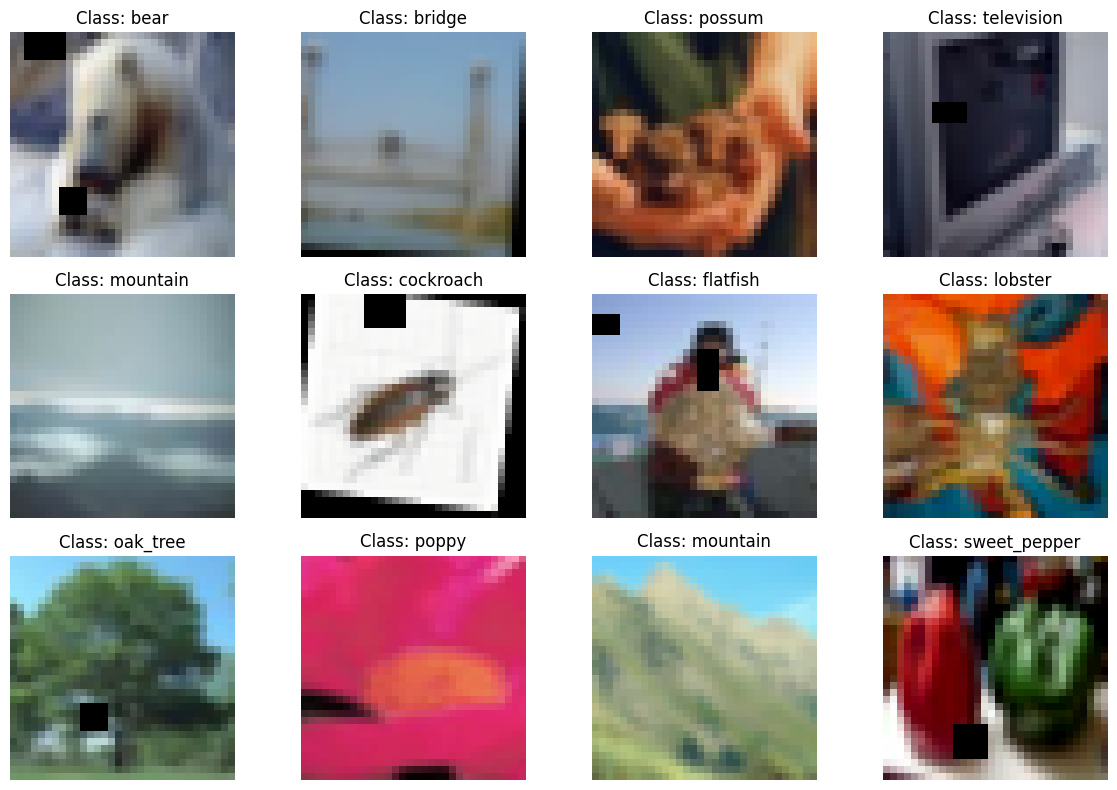

In [15]:
# Visualize augmented samples
import matplotlib.pyplot as plt
import numpy as np

batch_data, batch_label = next(iter(train_loader))
batch_data = batch_data.cpu().detach()

fig = plt.figure(figsize=(12, 8))
for i in range(12):
    img = batch_data[i].numpy().transpose((1, 2, 0))
    # Denormalize
    img = img * np.array(cifar100_std) + np.array(cifar100_mean)
    img = np.clip(img, 0, 1)

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Class: {cifar100_classes[batch_label[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
# WideResNet Architecture
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.equalInOut = in_planes == out_planes
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropRate = dropRate
        self.shortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, 1, stride=stride, bias=False) or None

    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.conv1(out if self.equalInOut else x)
        out = self.relu2(self.bn2(out))
        if self.dropRate > 0:
            out = F.dropout(out, p=self.dropRate, training=self.training)
        out = self.conv2(out)
        return out + (x if self.equalInOut else self.shortcut(x))


class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)

    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes,
                                i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)


class WideResNet(nn.Module):
    def __init__(self, depth=28, num_classes=100, widen_factor=10, dropRate=0.3):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert ((depth - 4) % 6 == 0)
        n = (depth - 4) // 6
        block = BasicBlock
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(-1, self.nChannels)
        return self.fc(out)

In [17]:
# Initialize model
model = WideResNet(depth=28, widen_factor=10, dropRate=0.3, num_classes=100).to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4          [-1, 160, 32, 32]          23,040
       BatchNorm2d-5          [-1, 160, 32, 32]             320
              ReLU-6          [-1, 160, 32, 32]               0
            Conv2d-7          [-1, 160, 32, 32]         230,400
            Conv2d-8          [-1, 160, 32, 32]           2,560
        BasicBlock-9          [-1, 160, 32, 32]               0
      BatchNorm2d-10          [-1, 160, 32, 32]             320
             ReLU-11          [-1, 160, 32, 32]               0
           Conv2d-12          [-1, 160, 32, 32]         230,400
      BatchNorm2d-13          [-1, 160, 32, 32]             320
             ReLU-14          [-1, 160,

In [18]:
# MixUp function
def mixup_data(x, y, alpha=0.2, device='cuda'):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [19]:
# Learning Rate Warmup Scheduler
class WarmupScheduler:
    def __init__(self, optimizer, warmup_epochs, initial_lr, target_lr, steps_per_epoch):
        self.optimizer = optimizer
        self.warmup_steps = warmup_epochs * steps_per_epoch
        self.initial_lr = initial_lr
        self.target_lr = target_lr
        self.current_step = 0

    def step(self):
        if self.current_step < self.warmup_steps:
            lr = self.initial_lr + (self.target_lr - self.initial_lr) * self.current_step / self.warmup_steps
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
        self.current_step += 1

    def is_warmup(self):
        return self.current_step < self.warmup_steps

In [20]:
# Training function with mixed precision and gradient clipping
def train(model, device, train_loader, optimizer, scheduler, warmup_scheduler, scaler, epoch,
          use_mixup=True, mixup_alpha=0.2, label_smoothing=0.1):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    total_loss = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Mixed precision training
        with autocast():
            if use_mixup:
                inputs, targets_a, targets_b, lam = mixup_data(data, target, alpha=mixup_alpha, device=device)
                outputs = model(inputs)
                loss = lam * F.cross_entropy(outputs, targets_a, label_smoothing=label_smoothing) + \
                       (1 - lam) * F.cross_entropy(outputs, targets_b, label_smoothing=label_smoothing)
            else:
                outputs = model(data)
                loss = F.cross_entropy(outputs, target, label_smoothing=label_smoothing)

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()

        # Update learning rate
        if warmup_scheduler.is_warmup():
            warmup_scheduler.step()
        else:
            scheduler.step()

        # Accuracy tracking
        _, pred = outputs.max(1)
        if use_mixup:
            correct += lam * pred.eq(targets_a).sum().item() + (1 - lam) * pred.eq(targets_b).sum().item()
        else:
            correct += pred.eq(target).sum().item()
        processed += len(data)
        total_loss += loss.item()

        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_description(f"Epoch {epoch} Loss={loss.item():.4f} Acc={100*correct/processed:.2f}% LR={current_lr:.6f}")

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / processed
    return avg_loss, accuracy


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n")
    return test_loss, accuracy

In [21]:
# Training Configuration
print("=" * 70)
print("Training Configuration:")
print("=" * 70)
print(f"Model: WideResNet-28-10 (36.5M parameters)")
print(f"Batch Size: {BATCH_SIZE}")
print(f"MixUp Alpha: 0.2")
print(f"Label Smoothing: 0.1")
print(f"Weight Decay: 1e-3")
print(f"Gradient Clipping: 1.0")
print(f"Scheduler: CosineAnnealingWarmRestarts")
print(f"Warmup: 5 epochs (0.01 -> 0.1)")
print(f"Mixed Precision: Enabled")
print("=" * 70)

# Optimizer and Scheduler
EPOCHS = 100
WARMUP_EPOCHS = 5
INITIAL_LR = 0.01
MAX_LR = 0.1
MIN_LR = 1e-4

optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=0.9, weight_decay=1e-3)

# Cosine annealing with warm restarts (T_0 = 25 epochs per cycle)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=25, T_mult=1, eta_min=MIN_LR)

# Warmup scheduler
warmup_scheduler = WarmupScheduler(optimizer, WARMUP_EPOCHS, INITIAL_LR, MAX_LR, len(train_loader))

# Gradient scaler for mixed precision
scaler = GradScaler()

# Tracking variables
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
learning_rates = []

# Early stopping and checkpointing
best_test_acc = 0.0
patience = 15
patience_counter = 0
os.makedirs(checkpoint_dir, exist_ok=True)

Training Configuration:
Model: WideResNet-28-10 (36.5M parameters)
Batch Size: 256
MixUp Alpha: 0.2
Label Smoothing: 0.1
Weight Decay: 1e-3
Gradient Clipping: 1.0
Scheduler: CosineAnnealingWarmRestarts
Warmup: 5 epochs (0.01 -> 0.1)
Mixed Precision: Enabled


/tmp/ipython-input-1447931344.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [40]:
# Training Loop
print("\nStarting training...\n")

for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss, train_acc = train(
        model, device, train_loader, optimizer, scheduler, warmup_scheduler, scaler, epoch,
        use_mixup=True, mixup_alpha=0.2, label_smoothing=0.1
    )

    # Test
    test_loss, test_acc = test(model, device, test_loader)

    # Record metrics
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    learning_rates.append(optimizer.param_groups[0]['lr'])

    # Save best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_accuracy': test_acc,
            'train_accuracy': train_acc,
        }, os.path.join(checkpoint_dir, 'best_model.pth'))
        print(f"*** New best model saved! Test Accuracy: {best_test_acc:.2f}% ***")
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch}. No improvement for {patience} epochs.")
        break

    # Check if target reached
    if test_acc >= 74.0:
        print(f"\n{'=' * 70}")
        print(f"Target accuracy of 74% reached at epoch {epoch}!")
        print(f"Final test accuracy: {test_acc:.2f}%")
        print(f"{'=' * 70}")
        break

    print(f"Best Test Accuracy so far: {best_test_acc:.2f}% | Patience: {patience_counter}/{patience}\n")

print(f"\nTraining completed. Best test accuracy: {best_test_acc:.2f}%")


Starting training...



  0%|          | 0/196 [00:00<?, ?it/s]/tmp/ipython-input-1052289112.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 Loss=4.1180 Acc=9.51% LR=0.027908: 100%|██████████| 196/196 [01:56<00:00,  1.69it/s]



Test set: Average loss: 3.8212, Accuracy: 1139/10000 (11.39%)

*** New best model saved! Test Accuracy: 11.39% ***
Best Test Accuracy so far: 11.39% | Patience: 0/15



Epoch 2 Loss=3.6456 Acc=12.64% LR=0.045908: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 3.4934, Accuracy: 1699/10000 (16.99%)

*** New best model saved! Test Accuracy: 16.99% ***
Best Test Accuracy so far: 16.99% | Patience: 0/15



Epoch 3 Loss=3.5458 Acc=18.46% LR=0.063908: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 3.2174, Accuracy: 2122/10000 (21.22%)

*** New best model saved! Test Accuracy: 21.22% ***
Best Test Accuracy so far: 21.22% | Patience: 0/15



Epoch 4 Loss=3.4197 Acc=23.13% LR=0.081908: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 3.0677, Accuracy: 2547/10000 (25.47%)

*** New best model saved! Test Accuracy: 25.47% ***
Best Test Accuracy so far: 25.47% | Patience: 0/15



Epoch 5 Loss=3.4668 Acc=26.86% LR=0.099908: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 2.8401, Accuracy: 2838/10000 (28.38%)

*** New best model saved! Test Accuracy: 28.38% ***
Best Test Accuracy so far: 28.38% | Patience: 0/15



Epoch 6 Loss=2.7612 Acc=35.33% LR=0.000712: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 2.1779, Accuracy: 4347/10000 (43.47%)

*** New best model saved! Test Accuracy: 43.47% ***
Best Test Accuracy so far: 43.47% | Patience: 0/15



Epoch 7 Loss=3.3170 Acc=36.27% LR=0.002398: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 2.1392, Accuracy: 4452/10000 (44.52%)

*** New best model saved! Test Accuracy: 44.52% ***
Best Test Accuracy so far: 44.52% | Patience: 0/15



Epoch 8 Loss=2.6149 Acc=38.32% LR=0.004739: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 2.1003, Accuracy: 4516/10000 (45.16%)

*** New best model saved! Test Accuracy: 45.16% ***
Best Test Accuracy so far: 45.16% | Patience: 0/15



Epoch 9 Loss=2.8060 Acc=39.26% LR=0.007158: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 2.0680, Accuracy: 4627/10000 (46.27%)

*** New best model saved! Test Accuracy: 46.27% ***
Best Test Accuracy so far: 46.27% | Patience: 0/15



Epoch 10 Loss=2.7944 Acc=42.39% LR=0.009055: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.9973, Accuracy: 4773/10000 (47.73%)

*** New best model saved! Test Accuracy: 47.73% ***
Best Test Accuracy so far: 47.73% | Patience: 0/15



Epoch 11 Loss=2.4442 Acc=40.47% LR=0.009961: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.9654, Accuracy: 4859/10000 (48.59%)

*** New best model saved! Test Accuracy: 48.59% ***
Best Test Accuracy so far: 48.59% | Patience: 0/15



Epoch 12 Loss=2.8898 Acc=41.40% LR=0.000448: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.9418, Accuracy: 4932/10000 (49.32%)

*** New best model saved! Test Accuracy: 49.32% ***
Best Test Accuracy so far: 49.32% | Patience: 0/15



Epoch 13 Loss=2.6249 Acc=39.90% LR=0.001895: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.9442, Accuracy: 4920/10000 (49.20%)

Best Test Accuracy so far: 49.32% | Patience: 1/15



Epoch 14 Loss=3.3180 Acc=42.49% LR=0.004122: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.9196, Accuracy: 4968/10000 (49.68%)

*** New best model saved! Test Accuracy: 49.68% ***
Best Test Accuracy so far: 49.68% | Patience: 0/15



Epoch 15 Loss=2.4154 Acc=42.14% LR=0.006580: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.9039, Accuracy: 4993/10000 (49.93%)

*** New best model saved! Test Accuracy: 49.93% ***
Best Test Accuracy so far: 49.93% | Patience: 0/15



Epoch 16 Loss=2.8537 Acc=43.68% LR=0.008658: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.8649, Accuracy: 5114/10000 (51.14%)

*** New best model saved! Test Accuracy: 51.14% ***
Best Test Accuracy so far: 51.14% | Patience: 0/15



Epoch 17 Loss=2.9818 Acc=44.86% LR=0.009844: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.8279, Accuracy: 5166/10000 (51.66%)

*** New best model saved! Test Accuracy: 51.66% ***
Best Test Accuracy so far: 51.66% | Patience: 0/15



Epoch 18 Loss=3.0895 Acc=44.44% LR=0.000256: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.8047, Accuracy: 5240/10000 (52.40%)

*** New best model saved! Test Accuracy: 52.40% ***
Best Test Accuracy so far: 52.40% | Patience: 0/15



Epoch 19 Loss=2.3300 Acc=45.21% LR=0.001442: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 1.7876, Accuracy: 5287/10000 (52.87%)

*** New best model saved! Test Accuracy: 52.87% ***
Best Test Accuracy so far: 52.87% | Patience: 0/15



Epoch 20 Loss=2.3875 Acc=45.21% LR=0.003520: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.7808, Accuracy: 5267/10000 (52.67%)

Best Test Accuracy so far: 52.87% | Patience: 1/15



Epoch 21 Loss=2.3627 Acc=45.67% LR=0.005978: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.7881, Accuracy: 5255/10000 (52.55%)

Best Test Accuracy so far: 52.87% | Patience: 2/15



Epoch 22 Loss=2.2009 Acc=47.27% LR=0.008205: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.8362, Accuracy: 5203/10000 (52.03%)

Best Test Accuracy so far: 52.87% | Patience: 3/15



Epoch 23 Loss=2.4727 Acc=46.39% LR=0.009652: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 1.7775, Accuracy: 5276/10000 (52.76%)

Best Test Accuracy so far: 52.87% | Patience: 4/15



Epoch 24 Loss=3.9073 Acc=46.98% LR=0.000139: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.7043, Accuracy: 5481/10000 (54.81%)

*** New best model saved! Test Accuracy: 54.81% ***
Best Test Accuracy so far: 54.81% | Patience: 0/15



Epoch 25 Loss=2.2692 Acc=48.82% LR=0.001045: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 1.6881, Accuracy: 5522/10000 (55.22%)

*** New best model saved! Test Accuracy: 55.22% ***
Best Test Accuracy so far: 55.22% | Patience: 0/15



Epoch 26 Loss=3.9930 Acc=48.29% LR=0.002942: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.7140, Accuracy: 5482/10000 (54.82%)

Best Test Accuracy so far: 55.22% | Patience: 1/15



Epoch 27 Loss=2.9630 Acc=47.26% LR=0.005361: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.6877, Accuracy: 5558/10000 (55.58%)

*** New best model saved! Test Accuracy: 55.58% ***
Best Test Accuracy so far: 55.58% | Patience: 0/15



Epoch 28 Loss=2.5313 Acc=47.21% LR=0.007702: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.7674, Accuracy: 5392/10000 (53.92%)

Best Test Accuracy so far: 55.58% | Patience: 1/15



Epoch 29 Loss=3.4260 Acc=47.61% LR=0.009388: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.6729, Accuracy: 5592/10000 (55.92%)

*** New best model saved! Test Accuracy: 55.92% ***
Best Test Accuracy so far: 55.92% | Patience: 0/15



Epoch 30 Loss=2.3529 Acc=48.54% LR=0.010000: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.6419, Accuracy: 5698/10000 (56.98%)

*** New best model saved! Test Accuracy: 56.98% ***
Best Test Accuracy so far: 56.98% | Patience: 0/15



Epoch 31 Loss=2.2228 Acc=49.29% LR=0.000712: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.6512, Accuracy: 5634/10000 (56.34%)

Best Test Accuracy so far: 56.98% | Patience: 1/15



Epoch 32 Loss=2.3055 Acc=48.47% LR=0.002398: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.6528, Accuracy: 5686/10000 (56.86%)

Best Test Accuracy so far: 56.98% | Patience: 2/15



Epoch 33 Loss=2.4222 Acc=48.86% LR=0.004739: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.6692, Accuracy: 5701/10000 (57.01%)

*** New best model saved! Test Accuracy: 57.01% ***
Best Test Accuracy so far: 57.01% | Patience: 0/15



Epoch 34 Loss=3.1544 Acc=51.13% LR=0.007158: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.6885, Accuracy: 5630/10000 (56.30%)

Best Test Accuracy so far: 57.01% | Patience: 1/15



Epoch 35 Loss=2.2589 Acc=51.17% LR=0.009055: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.6048, Accuracy: 5826/10000 (58.26%)

*** New best model saved! Test Accuracy: 58.26% ***
Best Test Accuracy so far: 58.26% | Patience: 0/15



Epoch 36 Loss=2.2183 Acc=50.28% LR=0.009961: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.5668, Accuracy: 5924/10000 (59.24%)

*** New best model saved! Test Accuracy: 59.24% ***
Best Test Accuracy so far: 59.24% | Patience: 0/15



Epoch 37 Loss=3.5772 Acc=51.70% LR=0.000448: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 1.5838, Accuracy: 5900/10000 (59.00%)

Best Test Accuracy so far: 59.24% | Patience: 1/15



Epoch 38 Loss=3.2068 Acc=51.04% LR=0.001895: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.6044, Accuracy: 5841/10000 (58.41%)

Best Test Accuracy so far: 59.24% | Patience: 2/15



Epoch 39 Loss=2.4903 Acc=52.37% LR=0.004122: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.5995, Accuracy: 5841/10000 (58.41%)

Best Test Accuracy so far: 59.24% | Patience: 3/15



Epoch 40 Loss=2.0655 Acc=51.52% LR=0.006580: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.5860, Accuracy: 5912/10000 (59.12%)

Best Test Accuracy so far: 59.24% | Patience: 4/15



Epoch 41 Loss=2.1450 Acc=53.86% LR=0.008658: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.5934, Accuracy: 5927/10000 (59.27%)

*** New best model saved! Test Accuracy: 59.27% ***
Best Test Accuracy so far: 59.27% | Patience: 0/15



Epoch 42 Loss=2.1204 Acc=53.33% LR=0.009844: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.5501, Accuracy: 6030/10000 (60.30%)

*** New best model saved! Test Accuracy: 60.30% ***
Best Test Accuracy so far: 60.30% | Patience: 0/15



Epoch 43 Loss=3.1664 Acc=54.26% LR=0.000256: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 1.5503, Accuracy: 6020/10000 (60.20%)

Best Test Accuracy so far: 60.30% | Patience: 1/15



Epoch 44 Loss=2.0900 Acc=52.79% LR=0.001442: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 1.5936, Accuracy: 5960/10000 (59.60%)

Best Test Accuracy so far: 60.30% | Patience: 2/15



Epoch 45 Loss=2.9061 Acc=54.08% LR=0.003520: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 1.5342, Accuracy: 6094/10000 (60.94%)

*** New best model saved! Test Accuracy: 60.94% ***
Best Test Accuracy so far: 60.94% | Patience: 0/15



Epoch 46 Loss=2.3277 Acc=53.71% LR=0.005978: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.5908, Accuracy: 5962/10000 (59.62%)

Best Test Accuracy so far: 60.94% | Patience: 1/15



Epoch 47 Loss=3.7163 Acc=54.46% LR=0.008205: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.5722, Accuracy: 6033/10000 (60.33%)

Best Test Accuracy so far: 60.94% | Patience: 2/15



Epoch 48 Loss=1.9520 Acc=54.91% LR=0.009652: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.5106, Accuracy: 6156/10000 (61.56%)

*** New best model saved! Test Accuracy: 61.56% ***
Best Test Accuracy so far: 61.56% | Patience: 0/15



Epoch 49 Loss=3.6781 Acc=54.69% LR=0.000139: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.5064, Accuracy: 6182/10000 (61.82%)

*** New best model saved! Test Accuracy: 61.82% ***
Best Test Accuracy so far: 61.82% | Patience: 0/15



Epoch 50 Loss=1.9533 Acc=57.06% LR=0.001045: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.4966, Accuracy: 6221/10000 (62.21%)

*** New best model saved! Test Accuracy: 62.21% ***
Best Test Accuracy so far: 62.21% | Patience: 0/15



Epoch 51 Loss=3.4245 Acc=56.95% LR=0.002942: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.5169, Accuracy: 6176/10000 (61.76%)

Best Test Accuracy so far: 62.21% | Patience: 1/15



Epoch 52 Loss=2.0984 Acc=55.98% LR=0.005361: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.5663, Accuracy: 6170/10000 (61.70%)

Best Test Accuracy so far: 62.21% | Patience: 2/15



Epoch 53 Loss=2.1309 Acc=57.62% LR=0.007702: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.5222, Accuracy: 6226/10000 (62.26%)

*** New best model saved! Test Accuracy: 62.26% ***
Best Test Accuracy so far: 62.26% | Patience: 0/15



Epoch 54 Loss=1.8263 Acc=56.78% LR=0.009388: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.4843, Accuracy: 6264/10000 (62.64%)

*** New best model saved! Test Accuracy: 62.64% ***
Best Test Accuracy so far: 62.64% | Patience: 0/15



Epoch 55 Loss=1.8590 Acc=57.13% LR=0.010000: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.4652, Accuracy: 6373/10000 (63.73%)

*** New best model saved! Test Accuracy: 63.73% ***
Best Test Accuracy so far: 63.73% | Patience: 0/15



Epoch 56 Loss=1.8645 Acc=57.52% LR=0.000712: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 1.4574, Accuracy: 6400/10000 (64.00%)

*** New best model saved! Test Accuracy: 64.00% ***
Best Test Accuracy so far: 64.00% | Patience: 0/15



Epoch 57 Loss=1.9232 Acc=58.04% LR=0.002398: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 1.4767, Accuracy: 6384/10000 (63.84%)

Best Test Accuracy so far: 64.00% | Patience: 1/15



Epoch 58 Loss=1.9769 Acc=56.91% LR=0.004739: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 1.5099, Accuracy: 6246/10000 (62.46%)

Best Test Accuracy so far: 64.00% | Patience: 2/15



Epoch 59 Loss=3.6320 Acc=57.71% LR=0.007158: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 1.5161, Accuracy: 6270/10000 (62.70%)

Best Test Accuracy so far: 64.00% | Patience: 3/15



Epoch 60 Loss=3.6924 Acc=57.07% LR=0.009055: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.4885, Accuracy: 6304/10000 (63.04%)

Best Test Accuracy so far: 64.00% | Patience: 4/15



Epoch 61 Loss=2.0911 Acc=56.93% LR=0.009961: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 1.4300, Accuracy: 6516/10000 (65.16%)

*** New best model saved! Test Accuracy: 65.16% ***
Best Test Accuracy so far: 65.16% | Patience: 0/15



Epoch 62 Loss=2.0719 Acc=58.39% LR=0.000448: 100%|██████████| 196/196 [01:56<00:00,  1.69it/s]



Test set: Average loss: 1.4366, Accuracy: 6525/10000 (65.25%)

*** New best model saved! Test Accuracy: 65.25% ***
Best Test Accuracy so far: 65.25% | Patience: 0/15



Epoch 63 Loss=1.9547 Acc=57.96% LR=0.001895: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 1.4470, Accuracy: 6542/10000 (65.42%)

*** New best model saved! Test Accuracy: 65.42% ***
Best Test Accuracy so far: 65.42% | Patience: 0/15



Epoch 64 Loss=2.1126 Acc=58.01% LR=0.004122: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 1.4670, Accuracy: 6443/10000 (64.43%)

Best Test Accuracy so far: 65.42% | Patience: 1/15



Epoch 65 Loss=1.9994 Acc=59.39% LR=0.006580: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 1.5335, Accuracy: 6329/10000 (63.29%)

Best Test Accuracy so far: 65.42% | Patience: 2/15



Epoch 66 Loss=1.8539 Acc=60.93% LR=0.008658: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 1.5512, Accuracy: 6221/10000 (62.21%)

Best Test Accuracy so far: 65.42% | Patience: 3/15



Epoch 67 Loss=2.1609 Acc=59.90% LR=0.009844: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.4270, Accuracy: 6573/10000 (65.73%)

*** New best model saved! Test Accuracy: 65.73% ***
Best Test Accuracy so far: 65.73% | Patience: 0/15



Epoch 68 Loss=2.5488 Acc=61.49% LR=0.000256: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 1.3981, Accuracy: 6671/10000 (66.71%)

*** New best model saved! Test Accuracy: 66.71% ***
Best Test Accuracy so far: 66.71% | Patience: 0/15



Epoch 69 Loss=3.5282 Acc=61.05% LR=0.001442: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.4608, Accuracy: 6526/10000 (65.26%)

Best Test Accuracy so far: 66.71% | Patience: 1/15



Epoch 70 Loss=2.5335 Acc=61.27% LR=0.003520: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.4890, Accuracy: 6540/10000 (65.40%)

Best Test Accuracy so far: 66.71% | Patience: 2/15



Epoch 71 Loss=1.8502 Acc=58.86% LR=0.005978: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.5618, Accuracy: 6384/10000 (63.84%)

Best Test Accuracy so far: 66.71% | Patience: 3/15



Epoch 72 Loss=1.9096 Acc=59.27% LR=0.008205: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.5699, Accuracy: 6379/10000 (63.79%)

Best Test Accuracy so far: 66.71% | Patience: 4/15



Epoch 73 Loss=1.6692 Acc=63.08% LR=0.009652: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.4490, Accuracy: 6658/10000 (66.58%)

Best Test Accuracy so far: 66.71% | Patience: 5/15



Epoch 74 Loss=2.6851 Acc=63.56% LR=0.000139: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.3670, Accuracy: 6725/10000 (67.25%)

*** New best model saved! Test Accuracy: 67.25% ***
Best Test Accuracy so far: 67.25% | Patience: 0/15



Epoch 75 Loss=1.7068 Acc=63.37% LR=0.001045: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.3954, Accuracy: 6660/10000 (66.60%)

Best Test Accuracy so far: 67.25% | Patience: 1/15



Epoch 76 Loss=1.7424 Acc=61.40% LR=0.002942: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.4549, Accuracy: 6631/10000 (66.31%)

Best Test Accuracy so far: 67.25% | Patience: 2/15



Epoch 77 Loss=1.8328 Acc=63.20% LR=0.005361: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.4829, Accuracy: 6513/10000 (65.13%)

Best Test Accuracy so far: 67.25% | Patience: 3/15



Epoch 78 Loss=3.7013 Acc=62.74% LR=0.007702: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.5242, Accuracy: 6444/10000 (64.44%)

Best Test Accuracy so far: 67.25% | Patience: 4/15



Epoch 79 Loss=1.8686 Acc=62.60% LR=0.009388: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.4966, Accuracy: 6484/10000 (64.84%)

Best Test Accuracy so far: 67.25% | Patience: 5/15



Epoch 80 Loss=2.1726 Acc=63.84% LR=0.010000: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.3792, Accuracy: 6769/10000 (67.69%)

*** New best model saved! Test Accuracy: 67.69% ***
Best Test Accuracy so far: 67.69% | Patience: 0/15



Epoch 81 Loss=2.0646 Acc=64.96% LR=0.000712: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.3632, Accuracy: 6756/10000 (67.56%)

Best Test Accuracy so far: 67.69% | Patience: 1/15



Epoch 82 Loss=3.6104 Acc=62.94% LR=0.002398: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.4259, Accuracy: 6689/10000 (66.89%)

Best Test Accuracy so far: 67.69% | Patience: 2/15



Epoch 83 Loss=3.5914 Acc=64.60% LR=0.004739: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 1.4156, Accuracy: 6699/10000 (66.99%)

Best Test Accuracy so far: 67.69% | Patience: 3/15



Epoch 84 Loss=2.3706 Acc=63.16% LR=0.007158: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.4351, Accuracy: 6665/10000 (66.65%)

Best Test Accuracy so far: 67.69% | Patience: 4/15



Epoch 85 Loss=1.6619 Acc=64.89% LR=0.009055: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.4442, Accuracy: 6691/10000 (66.91%)

Best Test Accuracy so far: 67.69% | Patience: 5/15



Epoch 86 Loss=1.9997 Acc=65.82% LR=0.009961: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.3389, Accuracy: 6906/10000 (69.06%)

*** New best model saved! Test Accuracy: 69.06% ***
Best Test Accuracy so far: 69.06% | Patience: 0/15



Epoch 87 Loss=2.0851 Acc=65.53% LR=0.000448: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.3588, Accuracy: 6890/10000 (68.90%)

Best Test Accuracy so far: 69.06% | Patience: 1/15



Epoch 88 Loss=2.7327 Acc=66.58% LR=0.001895: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.3772, Accuracy: 6915/10000 (69.15%)

*** New best model saved! Test Accuracy: 69.15% ***
Best Test Accuracy so far: 69.15% | Patience: 0/15



Epoch 89 Loss=3.0693 Acc=65.68% LR=0.004122: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 1.3876, Accuracy: 6795/10000 (67.95%)

Best Test Accuracy so far: 69.15% | Patience: 1/15



Epoch 90 Loss=1.9209 Acc=61.83% LR=0.006580: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.3976, Accuracy: 6800/10000 (68.00%)

Best Test Accuracy so far: 69.15% | Patience: 2/15



Epoch 91 Loss=1.6441 Acc=65.30% LR=0.008658: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.3787, Accuracy: 6761/10000 (67.61%)

Best Test Accuracy so far: 69.15% | Patience: 3/15



Epoch 92 Loss=2.2123 Acc=66.79% LR=0.009844: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.3489, Accuracy: 6956/10000 (69.56%)

*** New best model saved! Test Accuracy: 69.56% ***
Best Test Accuracy so far: 69.56% | Patience: 0/15



Epoch 93 Loss=1.8026 Acc=64.93% LR=0.000256: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.3284, Accuracy: 6982/10000 (69.82%)

*** New best model saved! Test Accuracy: 69.82% ***
Best Test Accuracy so far: 69.82% | Patience: 0/15



Epoch 94 Loss=2.0407 Acc=65.85% LR=0.001442: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.3445, Accuracy: 6962/10000 (69.62%)

Best Test Accuracy so far: 69.82% | Patience: 1/15



Epoch 95 Loss=1.5456 Acc=66.81% LR=0.003520: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.3672, Accuracy: 6880/10000 (68.80%)

Best Test Accuracy so far: 69.82% | Patience: 2/15



Epoch 96 Loss=3.3563 Acc=64.48% LR=0.005978: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.4739, Accuracy: 6636/10000 (66.36%)

Best Test Accuracy so far: 69.82% | Patience: 3/15



Epoch 97 Loss=1.9803 Acc=65.64% LR=0.008205: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.3855, Accuracy: 6795/10000 (67.95%)

Best Test Accuracy so far: 69.82% | Patience: 4/15



Epoch 98 Loss=2.0297 Acc=67.35% LR=0.009652: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.3343, Accuracy: 7031/10000 (70.31%)

*** New best model saved! Test Accuracy: 70.31% ***
Best Test Accuracy so far: 70.31% | Patience: 0/15



Epoch 99 Loss=1.7689 Acc=67.31% LR=0.000139: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.3139, Accuracy: 7028/10000 (70.28%)

Best Test Accuracy so far: 70.31% | Patience: 1/15



Epoch 100 Loss=1.5785 Acc=67.03% LR=0.001045: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.3283, Accuracy: 7036/10000 (70.36%)

*** New best model saved! Test Accuracy: 70.36% ***
Best Test Accuracy so far: 70.36% | Patience: 0/15


Training completed. Best test accuracy: 70.36%


In [12]:
from huggingface_hub import HfApi

# Explicitly add the pytorch_model.bin file before pushing
api = HfApi()
api.upload_file(
    path_or_fileobj=os.path.join(checkpoint_dir, 'best_model.pth'),
    path_in_repo='best_model.pth',
    repo_id=REPO_ID,
    repo_type="model",
)

print(f"Model state dictionary saved locally to {os.path.join(checkpoint_dir, 'best_model.pth')} and uploaded to https://huggingface.co/{REPO_ID}")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...rive/erav4/best_model.pth:   2%|1         | 5.55MB /  292MB            

Model state dictionary saved locally to ./drive/MyDrive/erav4/best_model.pth and uploaded to https://huggingface.co/agileabhi/resnet-cifar100-custom


In [6]:
# Training Loop
print("\nStarting training...\n")
EPOCHS = 120
for epoch in range(101, EPOCHS + 1):
    # Train
    train_loss, train_acc = train(
        model, device, train_loader, optimizer, scheduler, warmup_scheduler, scaler, epoch,
        use_mixup=True, mixup_alpha=0.2, label_smoothing=0.1
    )

    # Test
    test_loss, test_acc = test(model, device, test_loader)

    # Record metrics
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    learning_rates.append(optimizer.param_groups[0]['lr'])

    # Save best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_accuracy': test_acc,
            'train_accuracy': train_acc,
        }, os.path.join(checkpoint_dir, 'best_model.pth'))
        print(f"*** New best model saved! Test Accuracy: {best_test_acc:.2f}% ***")
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch}. No improvement for {patience} epochs.")
        break

    # Check if target reached
    if test_acc >= 74.0:
        print(f"\n{'=' * 70}")
        print(f"Target accuracy of 74% reached at epoch {epoch}!")
        print(f"Final test accuracy: {test_acc:.2f}%")
        print(f"{'=' * 70}")
        break

    print(f"Best Test Accuracy so far: {best_test_acc:.2f}% | Patience: {patience_counter}/{patience}\n")

print(f"\nTraining completed. Best test accuracy: {best_test_acc:.2f}%")


Starting training...



NameError: name 'train' is not defined

In [ ]:
# Training Loop
print("\nStarting training...\n")
EPOCHS = 160
for epoch in range(121, EPOCHS + 1):
    # Train
    train_loss, train_acc = train(
        model, device, train_loader, optimizer, scheduler, warmup_scheduler, scaler, epoch,
        use_mixup=True, mixup_alpha=0.2, label_smoothing=0.1
    )

    # Test
    test_loss, test_acc = test(model, device, test_loader)

    # Record metrics
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    learning_rates.append(optimizer.param_groups[0]['lr'])

    # Save best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_accuracy': test_acc,
            'train_accuracy': train_acc,
        }, os.path.join(checkpoint_dir, 'best_model.pth'))
        print(f"*** New best model saved! Test Accuracy: {best_test_acc:.2f}% ***")
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch}. No improvement for {patience} epochs.")
        break

    # Check if target reached
    if test_acc >= 74.0:
        print(f"\n{'=' * 70}")
        print(f"Target accuracy of 74% reached at epoch {epoch}!")
        print(f"Final test accuracy: {test_acc:.2f}%")
        print(f"{'=' * 70}")
        break

    print(f"Best Test Accuracy so far: {best_test_acc:.2f}% | Patience: {patience_counter}/{patience}\n")

print(f"\nTraining completed. Best test accuracy: {best_test_acc:.2f}%")


Starting training...



  0%|          | 0/196 [00:00<?, ?it/s]/tmp/ipython-input-1052289112.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 101 Loss=1.8863 Acc=67.78% LR=0.002942: 100%|██████████| 196/196 [01:56<00:00,  1.69it/s]



Test set: Average loss: 1.3696, Accuracy: 7003/10000 (70.03%)

Best Test Accuracy so far: 70.36% | Patience: 1/15



Epoch 102 Loss=1.9480 Acc=67.19% LR=0.005361: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.3684, Accuracy: 6884/10000 (68.84%)

Best Test Accuracy so far: 70.36% | Patience: 2/15



Epoch 103 Loss=3.2720 Acc=69.83% LR=0.007702: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.5264, Accuracy: 6624/10000 (66.24%)

Best Test Accuracy so far: 70.36% | Patience: 3/15



Epoch 104 Loss=1.7047 Acc=67.94% LR=0.009388: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.3573, Accuracy: 6993/10000 (69.93%)

Best Test Accuracy so far: 70.36% | Patience: 4/15



Epoch 105 Loss=3.0541 Acc=69.14% LR=0.010000: 100%|██████████| 196/196 [01:54<00:00,  1.71it/s]



Test set: Average loss: 1.2980, Accuracy: 7097/10000 (70.97%)

*** New best model saved! Test Accuracy: 70.97% ***
Best Test Accuracy so far: 70.97% | Patience: 0/15



Epoch 106 Loss=1.7106 Acc=68.37% LR=0.000712: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.3178, Accuracy: 7087/10000 (70.87%)

Best Test Accuracy so far: 70.97% | Patience: 1/15



Epoch 107 Loss=1.4998 Acc=69.38% LR=0.002398: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 1.3269, Accuracy: 7063/10000 (70.63%)

Best Test Accuracy so far: 70.97% | Patience: 2/15



Epoch 108 Loss=2.4805 Acc=67.92% LR=0.004739: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 1.3637, Accuracy: 6984/10000 (69.84%)

Best Test Accuracy so far: 70.97% | Patience: 3/15



Epoch 109 Loss=1.6727 Acc=72.08% LR=0.007158: 100%|██████████| 196/196 [01:55<00:00,  1.69it/s]



Test set: Average loss: 1.3760, Accuracy: 6957/10000 (69.57%)

Best Test Accuracy so far: 70.97% | Patience: 4/15



Epoch 110 Loss=1.4538 Acc=67.39% LR=0.009055: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.3778, Accuracy: 6958/10000 (69.58%)

Best Test Accuracy so far: 70.97% | Patience: 5/15



Epoch 111 Loss=2.0192 Acc=69.66% LR=0.009961: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.2627, Accuracy: 7210/10000 (72.10%)

*** New best model saved! Test Accuracy: 72.10% ***
Best Test Accuracy so far: 72.10% | Patience: 0/15



Epoch 112 Loss=1.6566 Acc=70.07% LR=0.000448: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.3021, Accuracy: 7152/10000 (71.52%)

Best Test Accuracy so far: 72.10% | Patience: 1/15



Epoch 113 Loss=1.4627 Acc=68.93% LR=0.001895: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.3015, Accuracy: 7156/10000 (71.56%)

Best Test Accuracy so far: 72.10% | Patience: 2/15



Epoch 114 Loss=3.3178 Acc=71.24% LR=0.004122: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.3158, Accuracy: 7114/10000 (71.14%)

Best Test Accuracy so far: 72.10% | Patience: 3/15



Epoch 115 Loss=1.5387 Acc=71.23% LR=0.006580: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.3861, Accuracy: 7053/10000 (70.53%)

Best Test Accuracy so far: 72.10% | Patience: 4/15



Epoch 116 Loss=1.6006 Acc=71.32% LR=0.008658: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.4371, Accuracy: 6860/10000 (68.60%)

Best Test Accuracy so far: 72.10% | Patience: 5/15



Epoch 117 Loss=1.6468 Acc=70.35% LR=0.009844: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]



Test set: Average loss: 1.2705, Accuracy: 7207/10000 (72.07%)

Best Test Accuracy so far: 72.10% | Patience: 6/15



Epoch 118 Loss=1.5609 Acc=69.88% LR=0.000256: 100%|██████████| 196/196 [01:55<00:00,  1.70it/s]


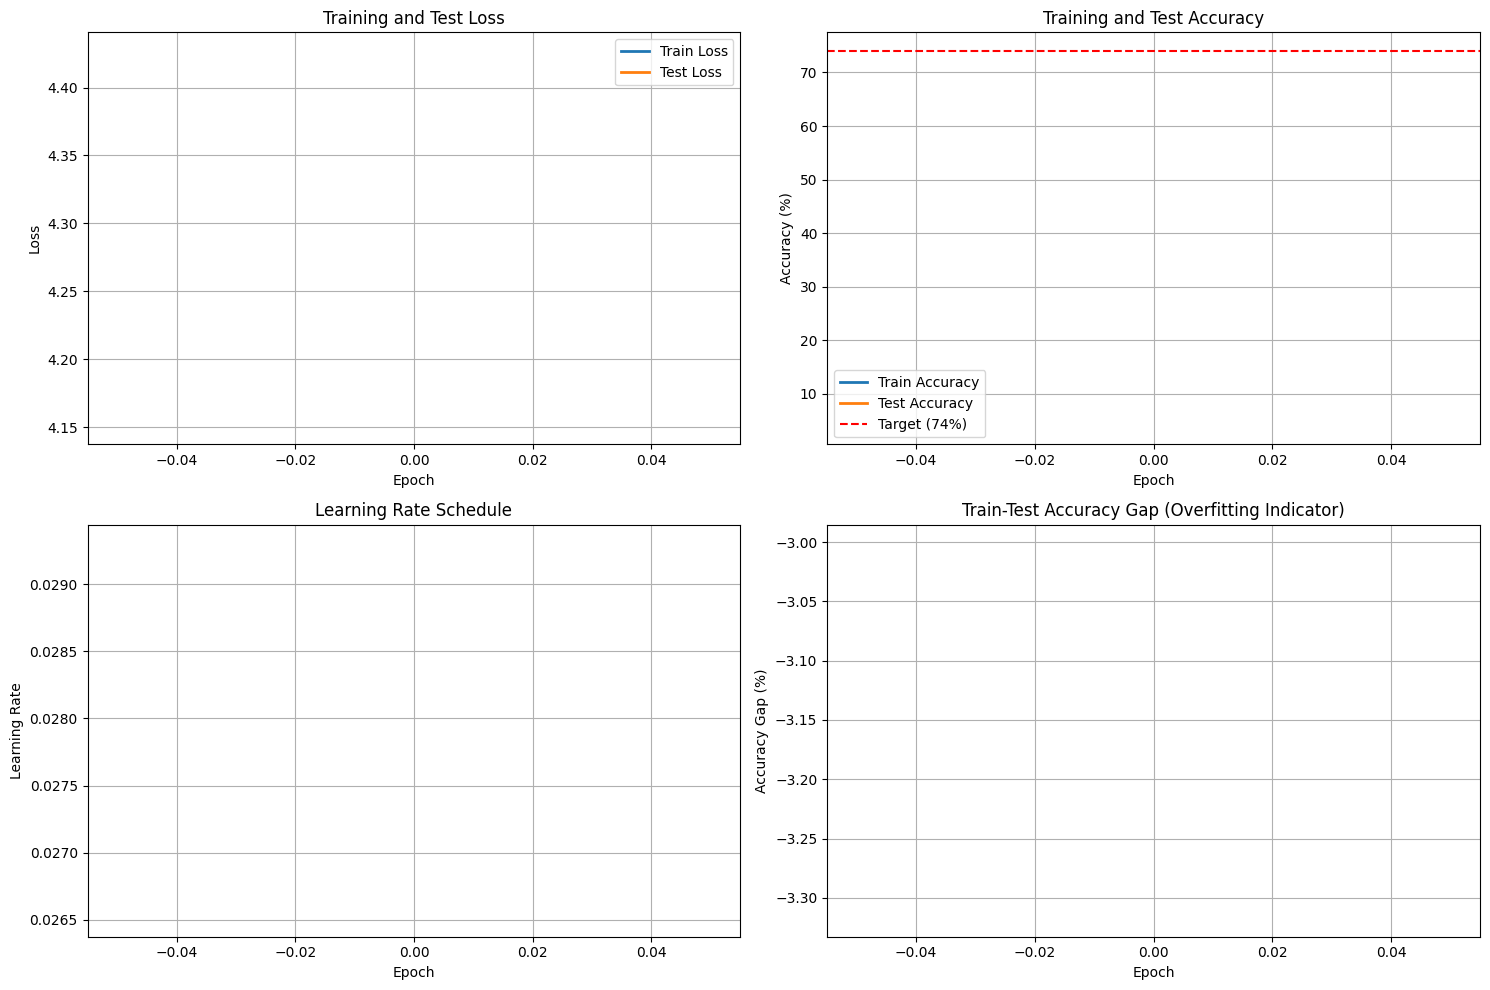


Final Statistics:
Best Test Accuracy: 7.22%
Final Train Accuracy: 4.06%
Final Test Accuracy: 7.22%
Final Train-Test Gap: -3.16%


In [38]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
axes[0, 0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0, 0].plot(test_losses, label='Test Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Test Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy curves
axes[0, 1].plot(train_accuracies, label='Train Accuracy', linewidth=2)
axes[0, 1].plot(test_accuracies, label='Test Accuracy', linewidth=2)
axes[0, 1].axhline(y=74, color='r', linestyle='--', label='Target (74%)')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training and Test Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Learning rate
axes[1, 0].plot(learning_rates, linewidth=2, color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].grid(True)

# Gap between train and test accuracy (overfitting indicator)
accuracy_gap = [train - test for train, test in zip(train_accuracies, test_accuracies)]
axes[1, 1].plot(accuracy_gap, linewidth=2, color='orange')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy Gap (%)')
axes[1, 1].set_title('Train-Test Accuracy Gap (Overfitting Indicator)')
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFinal Statistics:")
print(f"Best Test Accuracy: {best_test_acc:.2f}%")
print(f"Final Train Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")
print(f"Final Train-Test Gap: {accuracy_gap[-1]:.2f}%")

In [ ]:
# Load best model and evaluate
checkpoint = torch.load(os.path.join(checkpoint_dir, 'best_model.pth'))
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']} with test accuracy: {checkpoint['test_accuracy']:.2f}%")

# Final evaluation
test_loss, test_acc = test(model, device, test_loader)
print(f"\nFinal Test Accuracy: {test_acc:.2f}%")

Loaded best model from epoch 1 with test accuracy: 6.60%

Test set: Average loss: 4.1397, Accuracy: 660/10000 (6.60%)


Final Test Accuracy: 6.60%
